# TP MEDICAL


## Init libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# Read the data
df = pd.read_csv("medical.csv", sep=';')

# Display the first 10 rows 
print(df.head(10))

           Disease Fever Cough Fatigue Difficulty Breathing  Age  Gender  \
0        Influenza   Yes    No     Yes                  Yes   19  Female   
1      Common Cold    No   Yes     Yes                   No   25  Female   
2           Eczema    No   Yes     Yes                   No   25  Female   
3           Asthma   Yes   Yes      No                  Yes   25    Male   
4           Asthma   Yes   Yes      No                  Yes   25    Male   
5           Eczema   Yes    No      No                   No   25  Female   
6        Influenza   Yes   Yes     Yes                  Yes   25  Female   
7        Influenza   Yes   Yes     Yes                  Yes   25  Female   
8  Hyperthyroidism    No   Yes      No                   No   28  Female   
9  Hyperthyroidism    No   Yes      No                   No   28  Female   

  Blood Pressure Cholesterol Level Outcome Variable  
0            Low            Normal         Positive  
1         Normal            Normal         Negative  
2

## Cleaning data



Missing values:
Disease                 0
Fever                   0
Cough                   0
Fatigue                 0
Difficulty Breathing    0
Age                     0
Gender                  0
Blood Pressure          0
Cholesterol Level       0
Outcome Variable        0
dtype: int64

Total number of rows after removing duplicates: 300
Colonnes restantes après suppression de 'Gender': ['Disease', 'Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Age', 'Blood Pressure', 'Cholesterol Level', 'Outcome Variable']


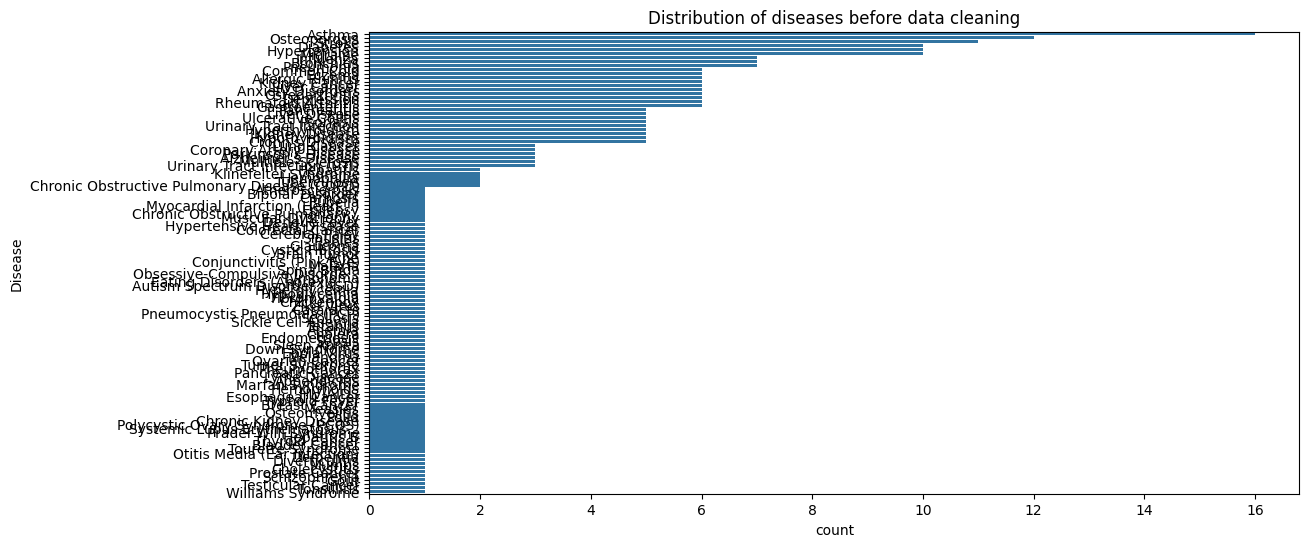

In [2]:
# Check for missing values in the dataset
print("\nMissing values:")
print(df.isnull().sum())

# Remove duplicate rows
df_cleaned = df.drop_duplicates()

# Verify the number of rows after removing duplicates
print(f"\nTotal number of rows after removing duplicates: {len(df_cleaned)}")

df_cleaned.drop(columns=["Gender"], errors='ignore', inplace=True)

# Verify the number of rows after removing gender column
print("Colonnes restantes après suppression de 'Gender':", df_cleaned.columns.tolist())

# Visualize the distribution of diseases before cleaning
plt.figure(figsize=(12, 6))
sns.countplot(data=df_cleaned, y='Disease', order=df_cleaned['Disease'].value_counts().index)
plt.title("Distribution of diseases before data cleaning")
plt.show()

# Create a new copy of the cleaned dataset for further processing
df_balanced = df_cleaned.copy()

## transforming data


Distribution des maladies avant filtrage :
 Disease
Asthma                                          16
Osteoporosis                                    12
Stroke                                          11
Diabetes                                        10
Hypertension                                    10
Migraine                                        10
Influenza                                        7
Bronchitis                                       7
Pneumonia                                        7
Common Cold                                      6
Eczema                                           6
Allergic Rhinitis                                6
Kidney Cancer                                    6
Liver Cancer                                     6
Anxiety Disorders                                6
Osteoarthritis                                   6
Depression                                       6
Rheumatoid Arthritis                             6
Gastroenteritis               

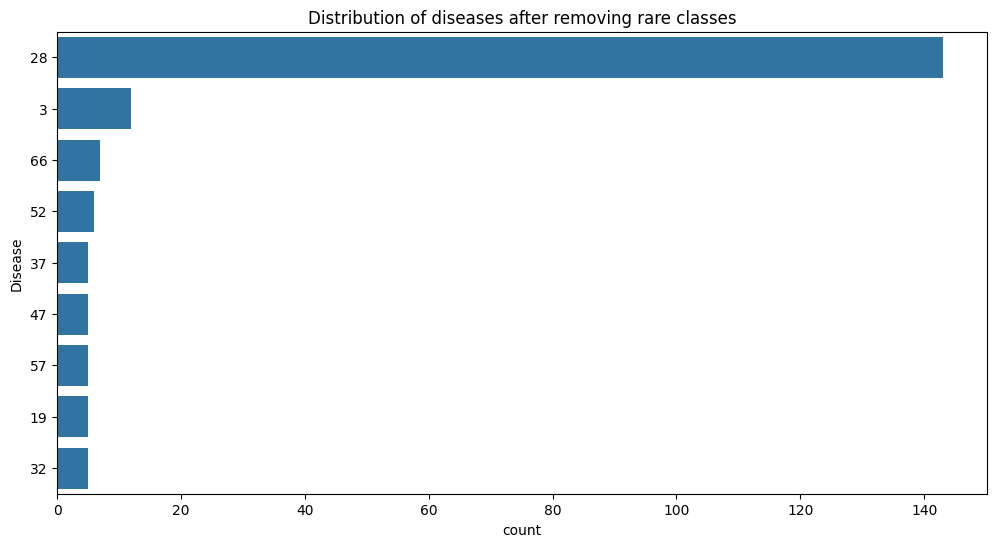

In [3]:
### Transforming Data

# Display all the disease before filtering
disease_counts_before = df_cleaned['Disease'].value_counts()
print("Distribution des maladies avant filtrage :\n", disease_counts_before.to_string())

# Assign "Healthy" as the disease category for negative cases
df_balanced.loc[df_balanced['Outcome Variable'] == 'Negative', 'Disease'] = 'Healthy'

# Verify the number of samples after adding negative cases
print("\nTotal number of samples after assign negative cases:", len(df_balanced))
print("\nDistribution of diseases after assign negative cases:")
print(df_balanced['Disease'].value_counts())


### Encoding categorical variables 

# Convert Yes/No values to 1/0 for numerical processing
df_balanced.replace({"Yes": 1, "No": 0}, inplace=True)

# Convert categorical values for Blood Pressure and Cholesterol Level into numeric representation
df_balanced["Blood Pressure"] = df_balanced["Blood Pressure"].map({"Low": 1, "Normal": 2, "High": 3}).astype(int)
df_balanced["Cholesterol Level"] = df_balanced["Cholesterol Level"].map({"Low": 1, "Normal": 2, "High": 3}).astype(int)

# Encode the "Disease" column using Label Encoding
encoder_disease = LabelEncoder()
df_balanced["Disease"] = encoder_disease.fit_transform(df_balanced["Disease"])

# Count the number of samples per disease after encoding
disease_counts = df_balanced["Disease"].value_counts()

# Remove classes (diseases) with fewer than 5 samples to ensure stability in training
valid_diseases = disease_counts[disease_counts >= 5].index
df_balanced = df_balanced[df_balanced["Disease"].isin(valid_diseases)]


# Display the remaining diseases
print("\nDisplay the remaining diseases (≥ 5 échantillons) :")
print(valid_diseases)

# Verify the distribution after removing rare disease classes
print("\nDistribution of diseases after removing rare classes (fewer than 5 samples):")
print(df_balanced["Disease"].value_counts())

# Display all the disease after filtering
disease_counts_after = df_balanced['Disease'].value_counts()
print("Distribution des maladies après filtrage :\n", disease_counts_after.to_string())

# Visualize the distribution of diseases after filtering out rare classes
plt.figure(figsize=(12, 6))
sns.countplot(data=df_balanced, y='Disease', order=df_balanced['Disease'].value_counts().index)
plt.title("Distribution of diseases after removing rare classes")
plt.show()

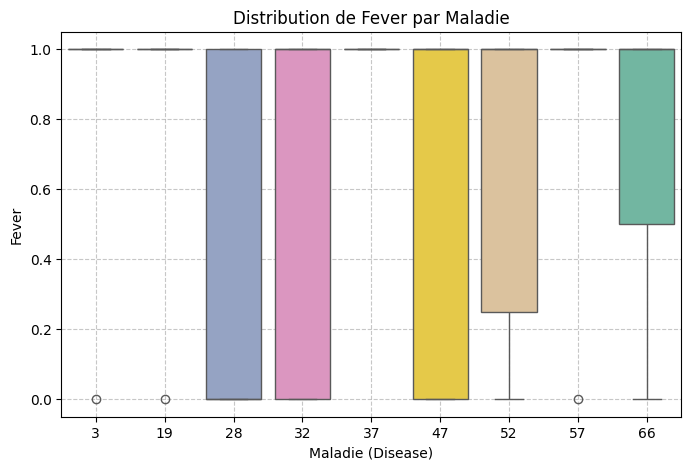

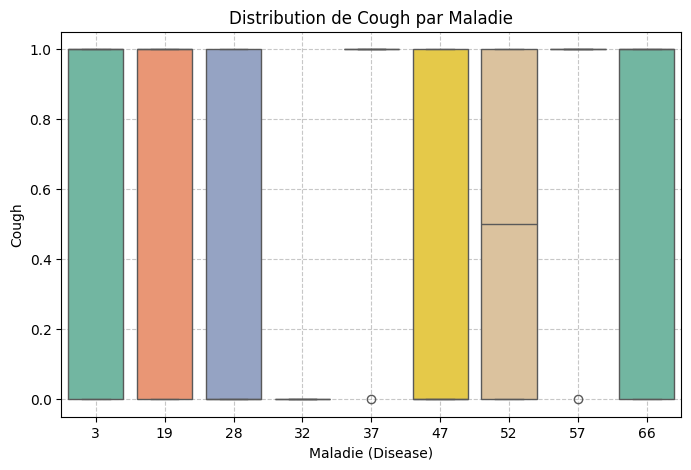

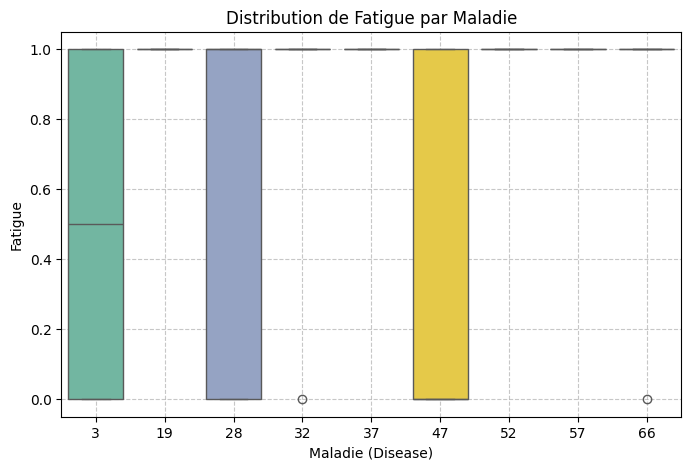

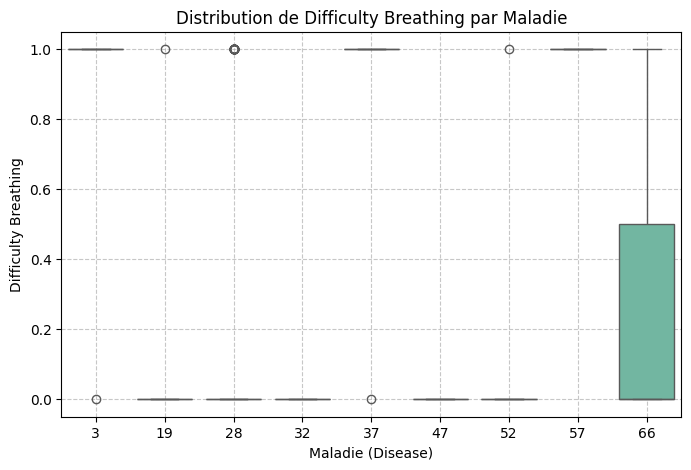

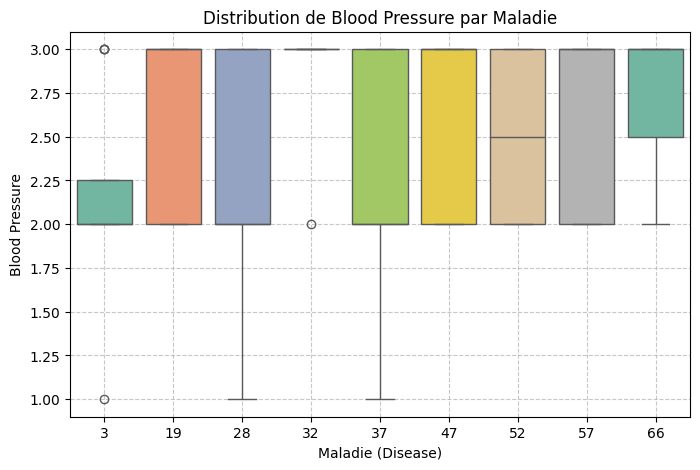

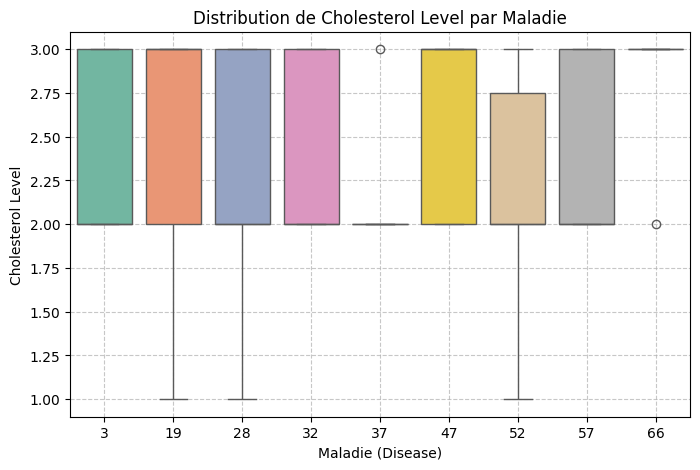

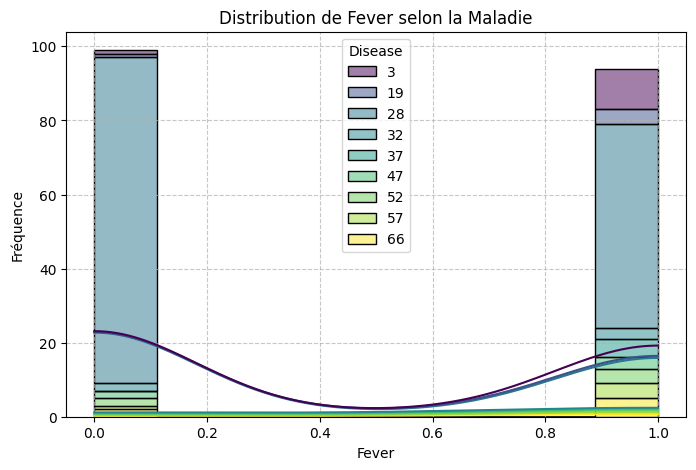

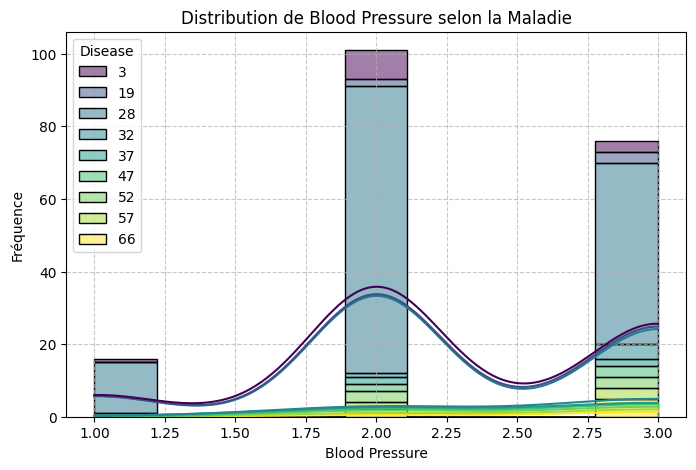

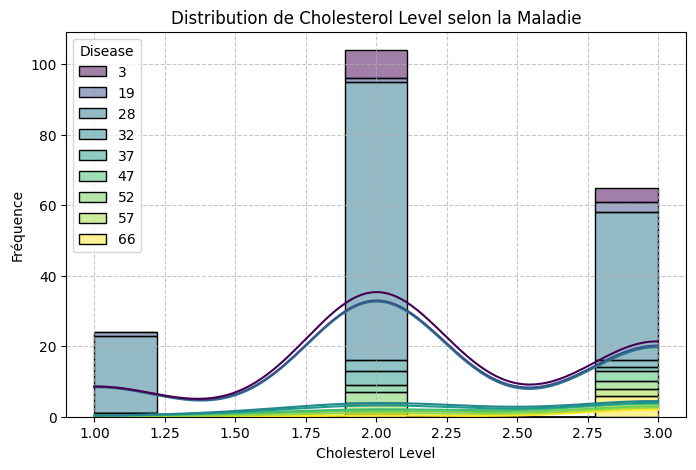

In [4]:
## visualize the distribution of the main variables
# statistical description of the dataset
desc_stats = df_balanced.describe()


# --- Boxplots symptom of disease ---
for col in ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Blood Pressure', 'Cholesterol Level']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_balanced, x='Disease', y=col, palette='Set2')
    plt.title(f"Distribution de {col} par Maladie")
    plt.xlabel("Maladie (Disease)")
    plt.ylabel(col)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()



# distribution of the main variables
for col in ['Fever', 'Blood Pressure', 'Cholesterol Level']:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_balanced, x=col, hue='Disease', multiple='stack', palette='viridis', kde=True)
    plt.title(f"Distribution de {col} selon la Maladie")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


## Preparing for training


In [5]:
# Define X (features) and y (target variable)
X = df_balanced[['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Blood Pressure', 'Cholesterol Level']]
y = df_balanced['Disease']

# Standardize the feature values for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to handle class imbalance by oversampling minority classes
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Verify the distribution of classes after applying SMOTE
print("\nClass distribution after applying SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Split the dataset into training and testing sets (85% train, 15% test) while maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled
)



Class distribution after applying SMOTE:
Disease
37    143
28    143
3     143
66    143
47    143
57    143
19    143
32    143
52    143
Name: count, dtype: int64


## TRAINING


Best SVC Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

=== SVM Results After SMOTE Balancing ===
Accuracy: 0.902
              precision    recall  f1-score   support

           3       0.94      0.76      0.84        21
          19       0.88      1.00      0.93        21
          28       0.81      0.59      0.68        22
          32       0.88      1.00      0.94        22
          37       0.95      0.95      0.95        22
          47       0.91      0.95      0.93        21
          52       1.00      0.95      0.98        22
          57       0.77      0.95      0.85        21
          66       1.00      0.95      0.98        22

    accuracy                           0.90       194
   macro avg       0.90      0.90      0.90       194
weighted avg       0.91      0.90      0.90       194



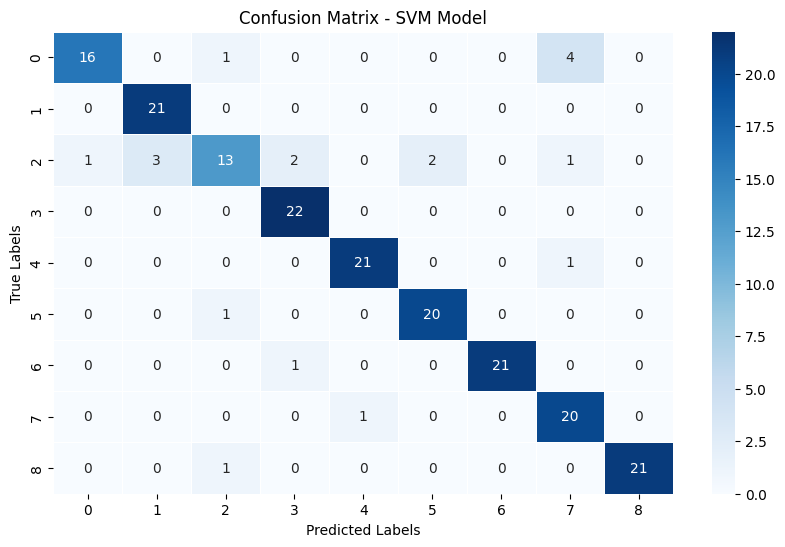

In [6]:
### Training and Optimizing SVM Model

# Define hyperparameter grid for tuning
param_grid = {
    'C': [1, 10, 50, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Types of kernel to test
    'gamma': ['scale', 'auto']  # Kernel coefficient for ‘rbf’ and ‘poly’
}

# Initialize SVM model with balanced class weights
svc = SVC(class_weight='balanced', random_state=42)

# GridSearchCV for hyperparameter tuning (5-fold cross-validation)
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the SVM model on the resampled dataset (balanced with SMOTE)
grid_search.fit(X_train, y_train)

# Display the best hyperparameters found
print("\nBest SVC Parameters:", grid_search.best_params_)

# Retrieve the best trained model
best_svc = grid_search.best_estimator_

### Evaluating the Optimized SVM Model

# Make predictions on the test set
y_pred = best_svc.predict(X_test)

# Print accuracy and classification report
print("\n=== SVM Results After SMOTE Balancing ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred))

### Confusion Matrix Visualization for SVM

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix - SVM Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200}

=== Optimized Random Forest Results ===
Accuracy: 0.912
              precision    recall  f1-score   support

           3       0.89      0.76      0.82        21
          19       0.88      1.00      0.93        21
          28       0.84      0.73      0.78        22
          32       0.95      0.95      0.95        22
          37       1.00      0.95      0.98        22
          47       0.90      0.90      0.90        21
          52       0.96      1.00      0.98        22
          57       0.79      0.90      0.84        21
          66       1.00      1.00      1.00        22

    accuracy                           0.91       194
   macro avg       0.91      0.91      0.91       194
weighted avg       0.91      0.91      0.91       194



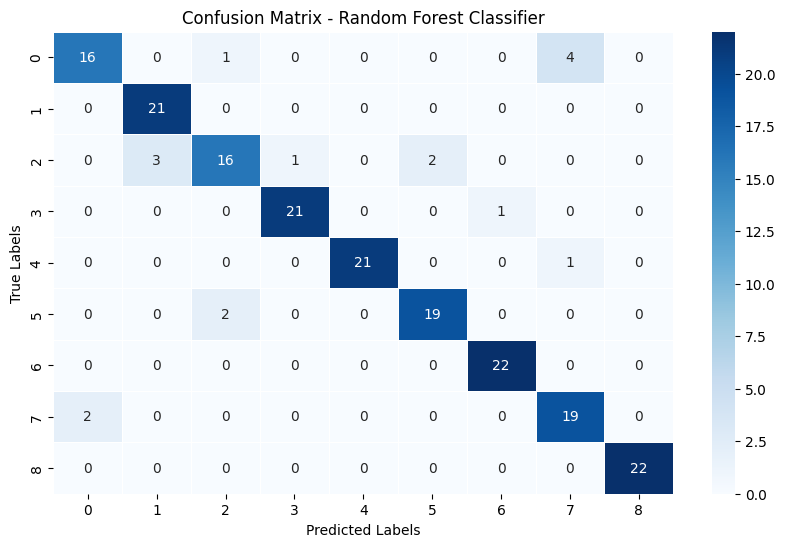

In [7]:
### Training and Optimizing Random Forest Classifier

# Define hyperparameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [5, 10, 15],  # Minimum samples required to split an internal node
    'min_samples_leaf': [3, 5, 10]  # Minimum samples required to be a leaf node
}

# Initialize Random Forest with balanced class weights
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# GridSearchCV for hyperparameter tuning (3-fold cross-validation)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)

# Train the Random Forest model on the training data
grid_search_rf.fit(X_train, y_train)

# Display the best hyperparameters found
print("\nBest Random Forest Parameters:", grid_search_rf.best_params_)

# Retrieve the best trained model
best_rf = grid_search_rf.best_estimator_

### Evaluating the Optimized Random Forest Model

# Make predictions on the test set
y_pred_rf_best = best_rf.predict(X_test)

# Print accuracy and classification report
print("\n=== Optimized Random Forest Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_best):.3f}")
print(classification_report(y_test, y_pred_rf_best))

### Confusion Matrix Visualization for Random Forest

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_best)

# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Fitting 2 folds for each of 48 candidates, totalling 96 fits

Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}

=== Optimized Gradient Boosting Results ===
Accuracy: 0.912
              precision    recall  f1-score   support

           3       0.84      0.76      0.80        21
          19       0.95      1.00      0.98        21
          28       0.83      0.68      0.75        22
          32       0.92      1.00      0.96        22
          37       1.00      0.95      0.98        22
          47       0.90      0.90      0.90        21
          52       1.00      1.00      1.00        22
          57       0.76      0.90      0.83        21
          66       1.00      1.00      1.00        22

    accuracy                           0.91       194
   macro avg       0.91      0.91      0.91       194
weighted avg       0.91      0.91      0.91       194



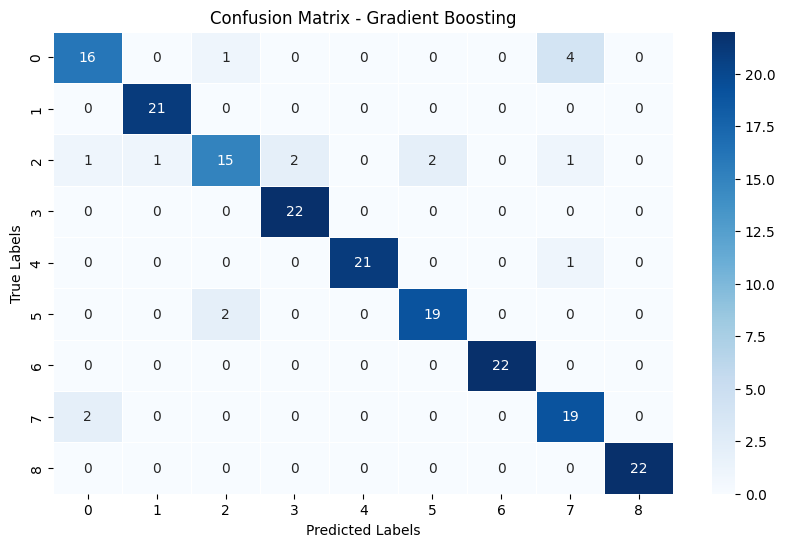

In [8]:
### Training and Optimizing Gradient Boosting Classifier

# Define hyperparameter grid for tuning
param_grid_gb = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'learning_rate': [0.05, 0.1],  # Step size shrinkage to prevent overfitting
    'max_depth': [3, 5],  # Maximum depth of individual trees
    'min_samples_split': [2, 5],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2]  # Minimum samples required at leaf nodes
}

# Initialize Gradient Boosting classifier
gb = GradientBoostingClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning (2-fold cross-validation)
grid_search_gb = GridSearchCV(
    gb, param_grid_gb, cv=2, scoring='accuracy', n_jobs=-1, verbose=2
)

# Train the Gradient Boosting model on the training data
grid_search_gb.fit(X_train, y_train)

# Display the best hyperparameters found
print("\nBest Gradient Boosting Parameters:", grid_search_gb.best_params_)

# Retrieve the best trained model
best_gb = grid_search_gb.best_estimator_

### Evaluating the Optimized Gradient Boosting Model

# Make predictions on the test set
y_pred_gb_best = best_gb.predict(X_test)

# Print accuracy and classification report
print("\n=== Optimized Gradient Boosting Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb_best):.3f}")
print(classification_report(y_test, y_pred_gb_best))

### Confusion Matrix Visualization for Gradient Boosting

# Compute confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb_best)

# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


## Visual results by model

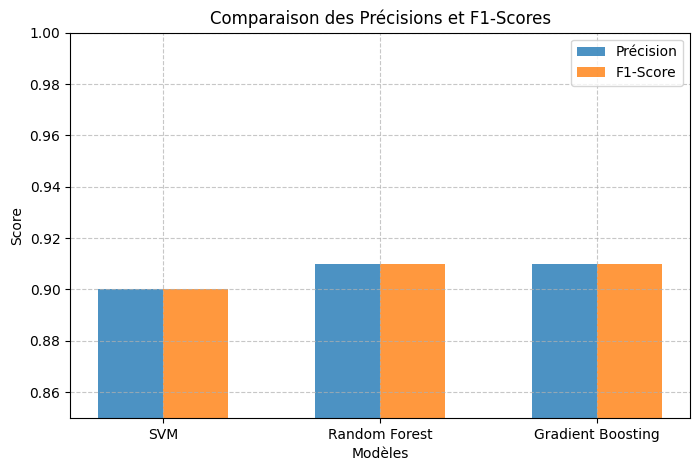

In [9]:
## For all model

models = ['SVM', 'Random Forest', 'Gradient Boosting']
precision = [0.90, 0.91, 0.91]
f1_score = [0.90, 0.91, 0.91]

x = np.arange(len(models))  
width = 0.3  

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, precision, width, label='Précision', alpha=0.8)
plt.bar(x + width/2, f1_score, width, label='F1-Score', alpha=0.8)

plt.xlabel('Modèles')
plt.ylabel('Score')
plt.title('Comparaison des Précisions et F1-Scores')
plt.xticks(x, models)
plt.ylim(0.85, 1.0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()